<a href="https://colab.research.google.com/github/aparedesum/ProductivityPrediction/blob/main/EvaluacionModelosProductividad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para el presente trabajo, se tomaron como referencias los siguientes trabajos:
- https://www.kaggle.com/code/eminecerit/notebook-garment-classification
- https://github.com/romeroc42/GarmentProductivity
- https://www.mikulskibartosz.name/xgboost-hyperparameter-tuning-in-python-using-grid-search/
- https://www.kaggle.com/code/sociopath00/random-forest-using-gridsearchcv/notebook
- https://www.aprendemachinelearning.com/clasificacion-con-datos-desbalanceados/

# **Cargamos el dataset**

In [518]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


In [519]:
df = pd.read_csv('garments_worker_productivity.csv')

# **Leyendo información del dataset**

In [520]:
print("Cantidad de filas y columnas: ", df.shape)
df.info()

Cantidad de filas y columnas:  (1197, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_product

In [521]:
# Información de la distribución de los datos en el dataset
df.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


In [522]:
#Detalle de las primeras filas del dataset
df.head(6)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
5,1/1/2015,Quarter1,sweing,Thursday,7,0.80,25.90,984.0,6720,38,0.0,0,0,56.0,0.800125


# **Pre procesamiento de datos**

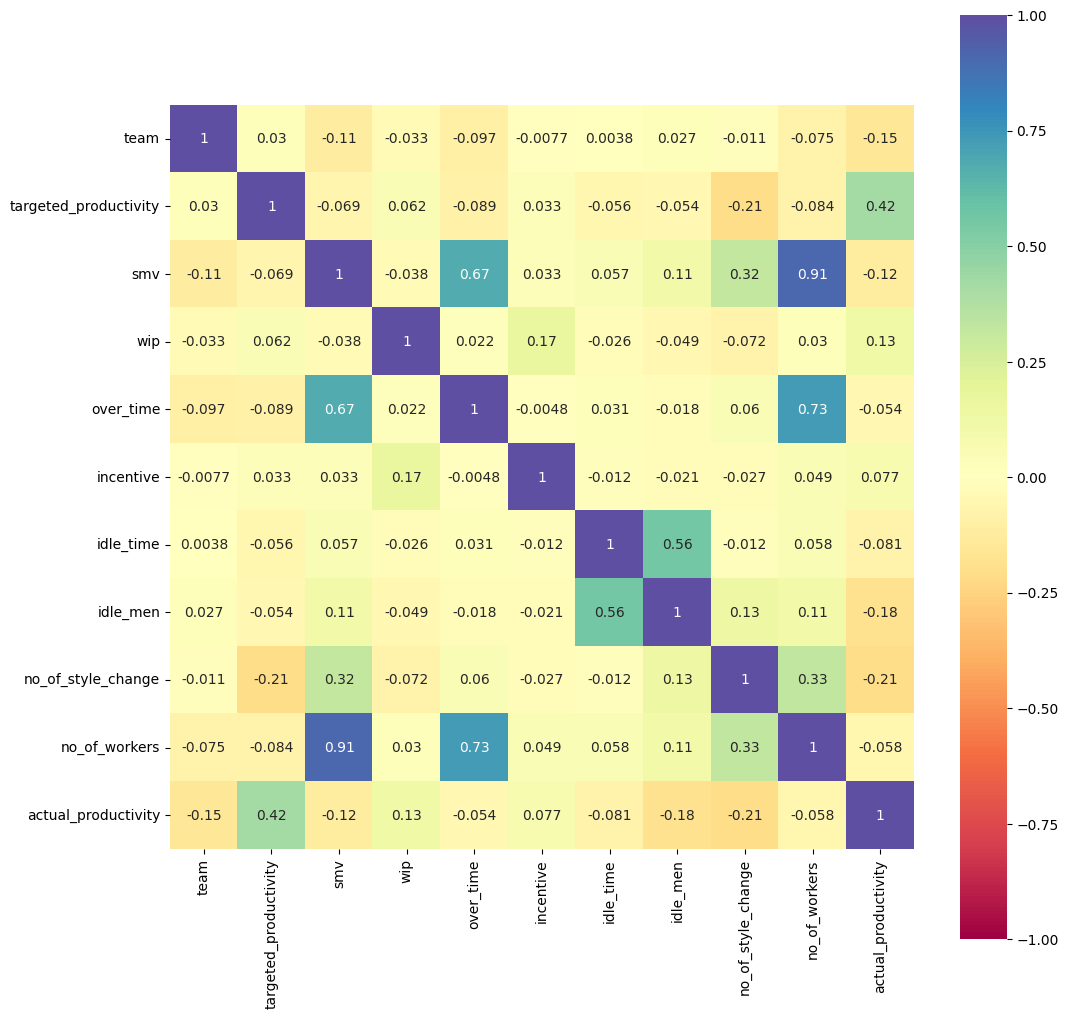

In [523]:
#Se puede evidenciar la influencia que tiene cada variable con el mapa de calor
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),
            annot=True,
            vmin=-1,
            vmax=1,
            cmap='Spectral',
            square=True
            )

In [524]:
# Obtenemos las columnas year, month, week, day_of_months en columnas separadas
# y renombramos la columna day->day_of_week
df["year"] = pd.DatetimeIndex(df['date']).year
df["month"] = pd.DatetimeIndex(df['date']).month
df["week"] = pd.DatetimeIndex(df['date']).week
df["day_of_month"] = pd.DatetimeIndex(df['date']).day
df.rename(columns = {"day":"day_of_week"}, inplace = True)

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


,date,quarter,department,day_of_week,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,year,month,week,day_of_month
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,2015,1,1,1
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,2015,1,1,1
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,2015,1,1,1
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,2015,1,1,1
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,2015,1,1,1


In [525]:
# Removemos columna year (debido a que todos son el mismo año) y date
df.drop(columns=["year"], inplace=True)
df.drop(columns=["date"], inplace=True)

In [526]:
# Analizando la columna quarter, department, day_of_week
print(df["quarter"].unique())
print(df["department"].unique())
print(df["day_of_week"].unique())

['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']
['sweing' 'finishing ' 'finishing']
['Thursday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']


In [527]:
# La columna department necesita limpiar espacios en los extremos
df['department'] = df['department'].str.strip()
#Corrigiendo el nombre de uno de los departamentos
df['department'] = df['department'].replace(['sweing'],['sewing'])

In [528]:
#Porcentaje de filas (registros) únicas por cada columna (variable). Mientras más cercano el valor a 1 significa que tiene más filas (registros) únicos
df.nunique()

quarter                    5
department                 2
day_of_week                6
team                      12
targeted_productivity      9
smv                       70
wip                      548
over_time                143
incentive                 48
idle_time                 12
idle_men                  10
no_of_style_change         3
no_of_workers             61
actual_productivity      879
month                      3
week                      11
day_of_month              30
dtype: int64

In [529]:
#Evaluamos los valores nulos o vacíos de las columnas
df.isna().sum()

quarter                    0
department                 0
day_of_week                0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
month                      0
week                       0
day_of_month               0
dtype: int64

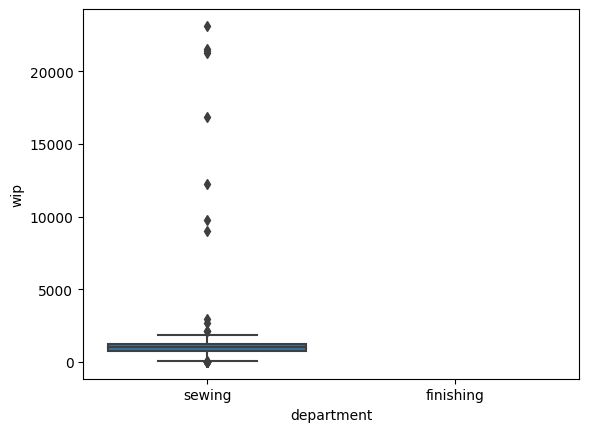

In [530]:
sns.boxplot(x='department',y='wip',data=df)

In [531]:
# Se observa que todos los nulos están en el departamento finishing
# Se asume que dicho departamento debe recibir el producto del departamento sewing
# para continuar el trabajo.
# Reemplamos los valores nan en la columna wip con el valor promedio

df["wip"].fillna(0, inplace = True)

In [532]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
categorical_features = ['quarter', 'department', 'day_of_week', 'team']

In [533]:
#Aplicando hot encoding a las variables categóricas
for column_name in categorical_features:
  dummies = pd.get_dummies(df[column_name],prefix=column_name)
  df = pd.concat([df,dummies],axis=1)


In [534]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["no_of_style_change_enc"] = le.fit_transform(df["no_of_style_change"])

In [535]:
#removiendo las columnas
df=df.drop(['quarter', 'department', 'day_of_week', 'team'],axis=1)

In [536]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   targeted_productivity   1197 non-null   float64
 1   smv                     1197 non-null   float64
 2   wip                     1197 non-null   float64
 3   over_time               1197 non-null   int64  
 4   incentive               1197 non-null   int64  
 5   idle_time               1197 non-null   float64
 6   idle_men                1197 non-null   int64  
 7   no_of_style_change      1197 non-null   int64  
 8   no_of_workers           1197 non-null   float64
 9   actual_productivity     1197 non-null   float64
 10  month                   1197 non-null   int64  
 11  week                    1197 non-null   int64  
 12  day_of_month            1197 non-null   int64  
 13  quarter_Quarter1        1197 non-null   uint8  
 14  quarter_Quarter2        1197 non-null   

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

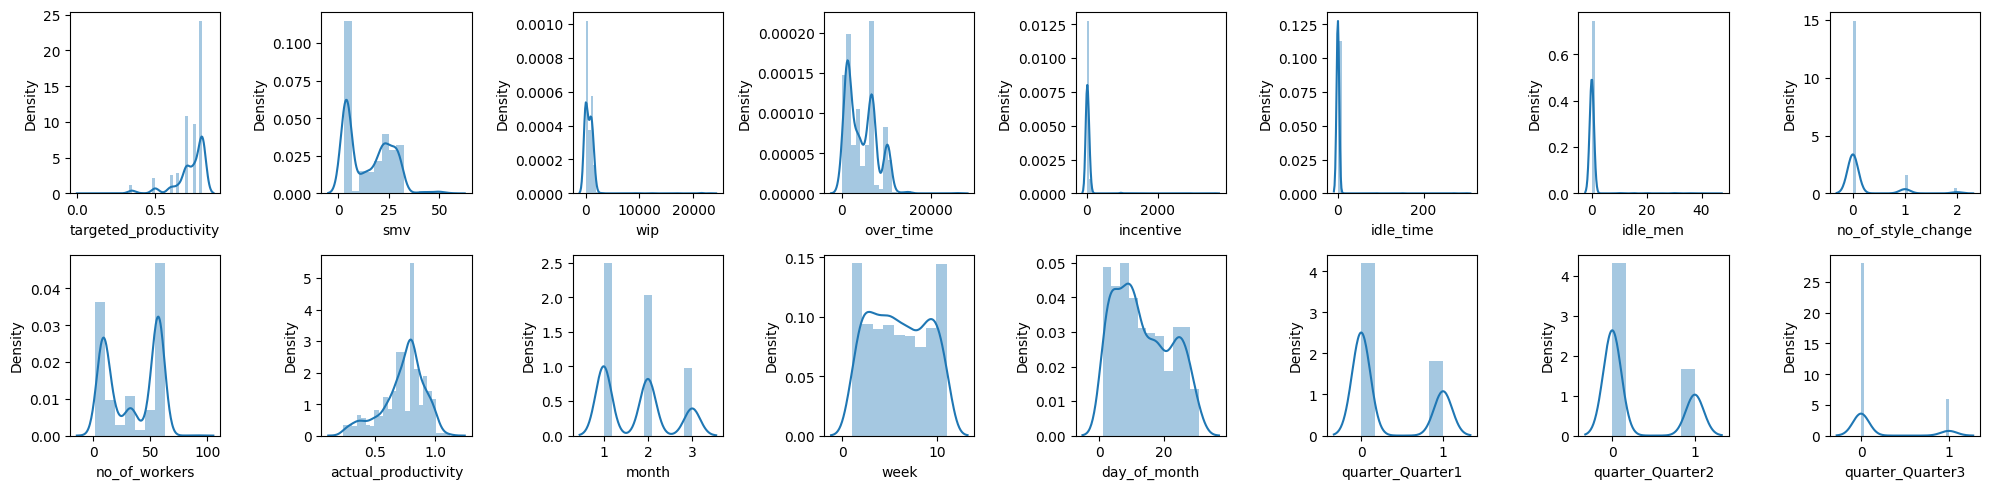

In [537]:
width = 20
height = 5

plt.style.use("default")

figure, axes = plt.subplots(nrows=2, ncols=8, figsize=(width, height))

for column, axe in zip(df, axes.flatten()):
    sns.distplot(df[column], ax=axe)
    
plt.tight_layout()

In [538]:
#Se crea la columna diferencia
df['diferencia'] = df.actual_productivity - df.targeted_productivity
df.columns


Index(['targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers',
       'actual_productivity', 'month', 'week', 'day_of_month',
       'quarter_Quarter1', 'quarter_Quarter2', 'quarter_Quarter3',
       'quarter_Quarter4', 'quarter_Quarter5', 'department_finishing',
       'department_sewing', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'team_1', 'team_2', 'team_3', 'team_4',
       'team_5', 'team_6', 'team_7', 'team_8', 'team_9', 'team_10', 'team_11',
       'team_12', 'no_of_style_change_enc', 'diferencia'],
      dtype='object')

In [539]:
#Detalle de la columna creada
df['diferencia'].describe()

count    1197.000000
mean        0.005459
std         0.160082
min        -0.561958
25%        -0.009556
50%         0.000505
75%         0.099111
max         0.644375
Name: diferencia, dtype: float64

In [540]:
#Creando una columna nueva para tener el target

df["Target"] = np.nan
df.loc[df['diferencia']<0,'Target']=-1
df.loc[(df['diferencia']>0), 'Target']=1
df.loc[df['diferencia']==0, 'Target']=0
df.head(6)

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,...,team_6,team_7,team_8,team_9,team_10,team_11,team_12,no_of_style_change_enc,diferencia,Target
0,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,...,0,0,1,0,0,0,0,0,0.140725,1.0
1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0.886500,...,0,0,0,0,0,0,0,0,0.136500,1.0
2,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,...,0,0,0,0,0,1,0,0,0.000570,1.0
3,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,...,0,0,0,0,0,0,1,0,0.000570,1.0
4,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,...,1,0,0,0,0,0,0,0,0.000382,1.0
5,0.80,25.90,984.0,6720,38,0.0,0,0,56.0,0.800125,...,0,1,0,0,0,0,0,0,0.000125,1.0


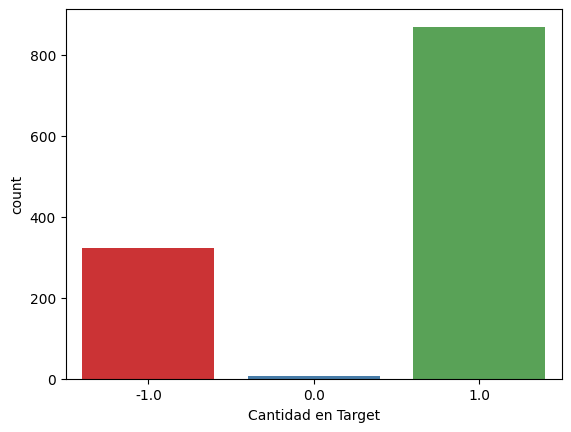

In [541]:
#Revisaremos si hay un desbalance es la variable Target
ax = sns.countplot(x='Target',data= df, palette ='Set1')
plt.xlabel("Cantidad en Target")
plt.show()

In [542]:
df['Target'].value_counts()

 1.0    869
-1.0    322
 0.0      6
Name: Target, dtype: int64

In [543]:
df['Target'] = [-1 if x==-1 else 1 for x in df['Target']]
df['Target'].value_counts()

 1    875
-1    322
Name: Target, dtype: int64

**Balanceando el target para llevarlo a los modelos**

In [544]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   targeted_productivity   1197 non-null   float64
 1   smv                     1197 non-null   float64
 2   wip                     1197 non-null   float64
 3   over_time               1197 non-null   int64  
 4   incentive               1197 non-null   int64  
 5   idle_time               1197 non-null   float64
 6   idle_men                1197 non-null   int64  
 7   no_of_style_change      1197 non-null   int64  
 8   no_of_workers           1197 non-null   float64
 9   actual_productivity     1197 non-null   float64
 10  month                   1197 non-null   int64  
 11  week                    1197 non-null   int64  
 12  day_of_month            1197 non-null   int64  
 13  quarter_Quarter1        1197 non-null   uint8  
 14  quarter_Quarter2        1197 non-null   

In [545]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


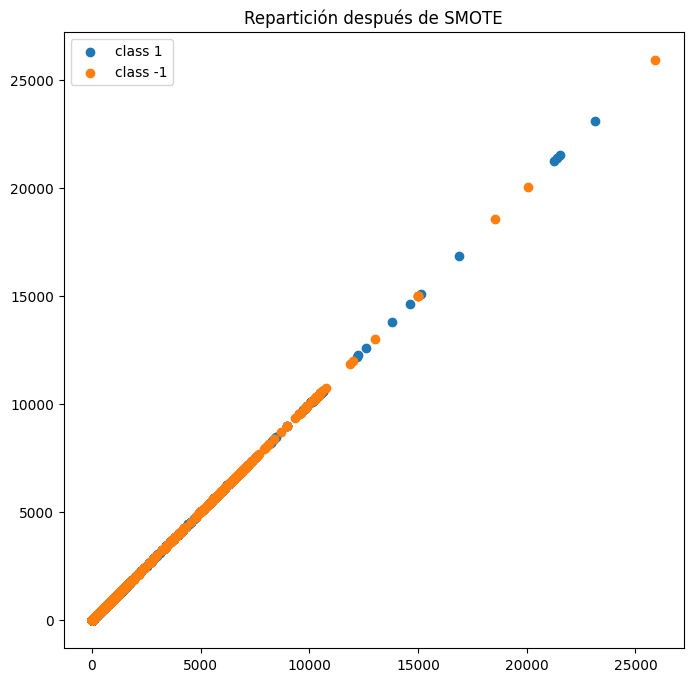

In [546]:
from imblearn.over_sampling import SMOTE
X = df.loc[:, df.columns != 'Target']
y = df.Target
smt = SMOTE()
X_smote, y_smote = smt.fit_resample(X, y)
plt.figure(figsize=(8, 8))
plt.title('Repartición después de SMOTE')

plt.scatter(X_smote[y_smote==1], X_smote[y_smote==1], label='class 1')
plt.scatter(X_smote[y_smote==-1], X_smote[y_smote==-1], label='class -1')
plt.legend()
plt.grid(False)
plt.show()

In [547]:
df= pd.concat([pd.DataFrame(X_smote), pd.DataFrame(y_smote)], axis=1)
df.shape

(1750, 41)

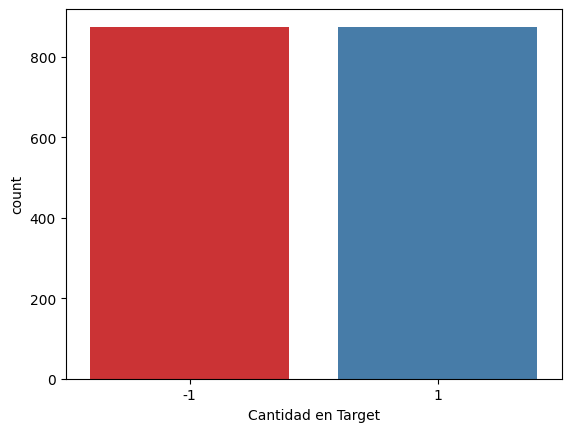

In [548]:
ax = sns.countplot(x='Target',data= df, palette ='Set1')
plt.xlabel("Cantidad en Target")
plt.show()

**Split a los datos**

In [549]:
#Separando la data en dos partes para aplica ML
X= df.drop('Target',axis=1)
y= df['Target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,random_state=0)

**Scaling**

In [550]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Aplicando ML**

In [551]:
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,roc_curve, roc_auc_score, precision_score,recall_score,accuracy_score,f1_score,confusion_matrix,plot_confusion_matrix,classification_report
import matplotlib.pyplot as plt

**1er Algoritmo: DecisionTreeClassifier**

Accuracy:  0.9828571428571429
MSE:  0.06857142857142857
MAE:  0.03428571428571429
Precision:  0.9837837837837837
Recall:  0.9824561403508771
f1-score:  0.9828296703296704


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


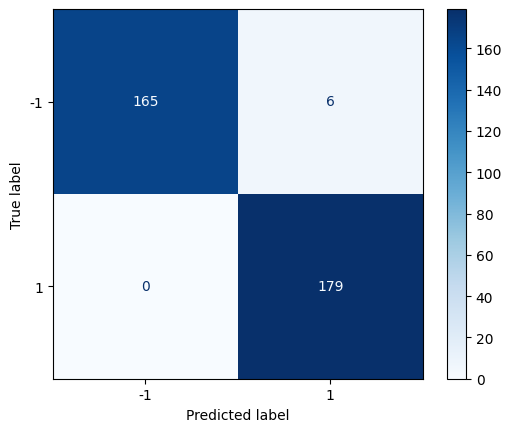

In [569]:
from sklearn.tree import DecisionTreeClassifier

decision_model = DecisionTreeClassifier(random_state=42, max_depth=2)
decision_model.fit(X_train, y_train)
y_pred = decision_model.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='macro'))
print('Recall: ', recall_score(y_test, y_pred,average='macro', zero_division=0))
print('f1-score: ', f1_score(y_test, y_pred,average='macro'))
plot_confusion_matrix(decision_model, X_test, y_test,cmap=plt.cm.Blues)

**2do Algoritmo: RandomForestClassifier**

Accuracy:  0.9857142857142858
MSE:  0.05714285714285714
MAE:  0.02857142857142857
Precision:  0.9860347985347986
Recall:  0.985510797477866
f1-score:  0.9857001609753306


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


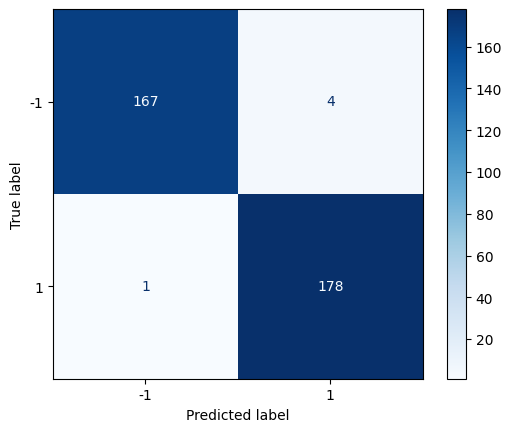

In [553]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(max_depth=10, random_state=42)
random_forest_model.fit(X_train,y_train)
y_pred = random_forest_model.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average="macro"))
print('Recall: ', recall_score(y_test, y_pred, average="macro", zero_division=0))
print('f1-score: ', f1_score(y_test, y_pred, average="macro"))
plot_confusion_matrix(random_forest_model, X_test, y_test,cmap=plt.cm.Blues)

**3er Algoritmo: SVM**

Accuracy:  0.82
MSE:  0.72
MAE:  0.36
Precision:  0.8375729774812344
Recall:  0.8173576399098303
f1-score:  0.816694515799187


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


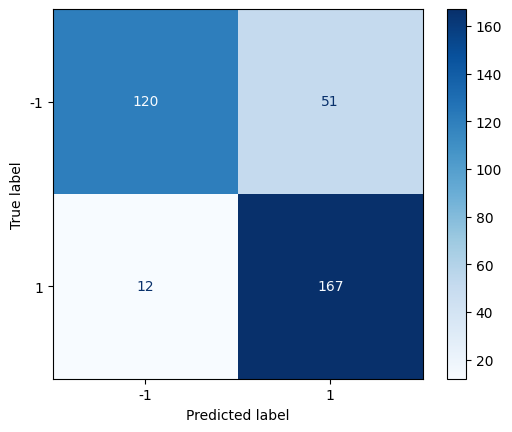

In [554]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

# El modelo SVC es bueno cuando se transforma la data.

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajuste de modelo con kernel gaussiano
svc_model = SVC(random_state=42, kernel='rbf', C=1, gamma=50)
svc_model.fit(X_train_scaled,y_train)

y_pred = svc_model.predict(X_test_scaled)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average="macro"))
print('Recall: ', recall_score(y_test, y_pred, average="macro", zero_division=0))
print('f1-score: ', f1_score(y_test, y_pred, average="macro"))

plot_confusion_matrix(svc_model, X_test_scaled, y_test,cmap=plt.cm.Blues)

**4to Algoritmo: GradientBoostingClassifier**

Accuracy:  0.9885714285714285
MSE:  0.045714285714285714
MAE:  0.022857142857142857
Precision:  0.9890710382513661
Recall:  0.9883040935672515
f1-score:  0.9885579783582334


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


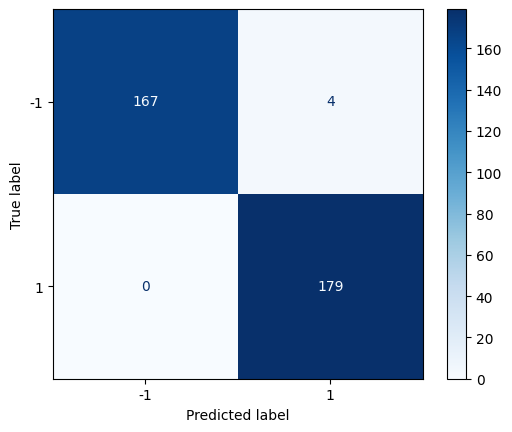

In [555]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average="macro"))
print('Recall: ', recall_score(y_test, y_pred, average="macro", zero_division=0))
print('f1-score: ', f1_score(y_test, y_pred, average="macro"))
plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues)


**Calculo de hiperparámetros**



**1. DecisionTreeClassifier**

In [575]:
parameters = {
              'max_depth' : [2, 5, 6, 7, 8, 9, 10],
              'criterion' :['gini', 'entropy']
             }
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), parameters, cv=10, verbose=True)
grid_search.fit(X_train, y_train)

print("Mejores hiper parametros:", grid_search.best_params_)
print("Mejor estimator:", grid_search.best_estimator_)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Mejores hiper parametros: {'criterion': 'entropy', 'max_depth': 6}
Mejor estimator: DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)


Accuracy:  0.9828571428571429
MSE:  0.06857142857142857
MAE:  0.03428571428571429
Precision:  0.9833447858381597
Recall:  0.9825868208696789
f1-score:  0.9828369675373501


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


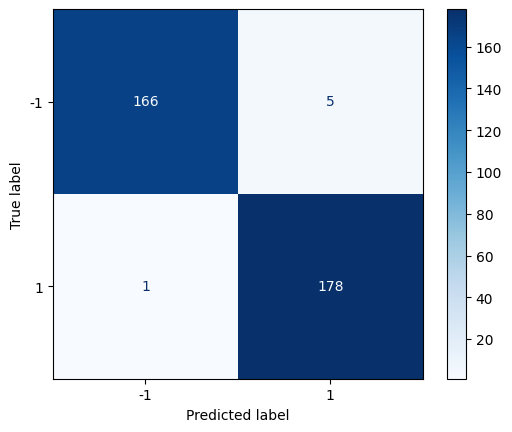

In [576]:
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average="macro"))
print('Recall: ', recall_score(y_test, y_pred, average="macro", zero_division=0))
print('f1-score: ', f1_score(y_test, y_pred, average="macro"))
plot_confusion_matrix(final_model, X_test, y_test,cmap=plt.cm.Blues)

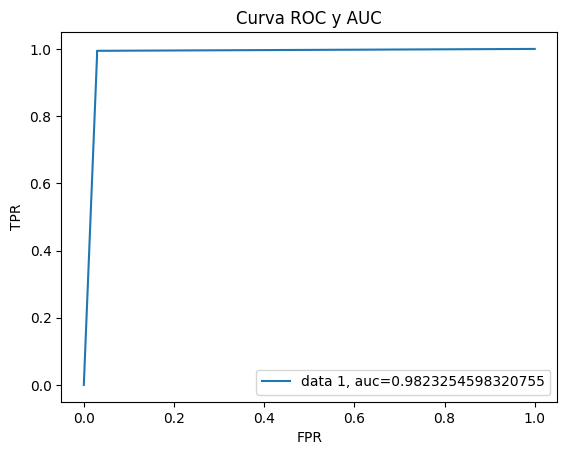

In [577]:
# ROC y AUC
y_pred_proba = final_model.predict_proba(X_test)[::,1]
fpr, tpr, th = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.title("Curva ROC y AUC")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()

**2. RandomForestClassifier**

In [578]:
parameters = { 
    'n_estimators': [50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10],
    'criterion' :['gini', 'entropy']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), parameters, cv=10, verbose=True)
grid_search.fit(X_train, y_train)
print("Mejores hiper parametros:", grid_search.best_params_)
print("Mejor estimator:", grid_search.best_estimator_)

Fitting 10 folds for each of 84 candidates, totalling 840 fits
Mejores hiper parametros: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 50}
Mejor estimator: RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=50,
                       random_state=42)


Accuracy:  0.9857142857142858
MSE:  0.05714285714285714
MAE:  0.02857142857142857
Precision:  0.9860347985347986
Recall:  0.985510797477866
f1-score:  0.9857001609753306


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


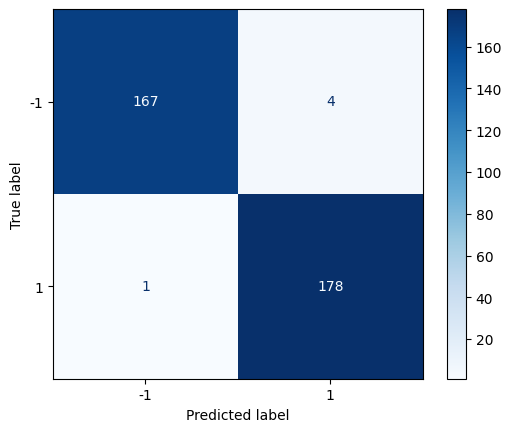

In [579]:
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average="macro"))
print('Recall: ', recall_score(y_test, y_pred, average="macro", zero_division=0))
print('f1-score: ', f1_score(y_test, y_pred, average="macro"))
plot_confusion_matrix(final_model, X_test, y_test,cmap=plt.cm.Blues)

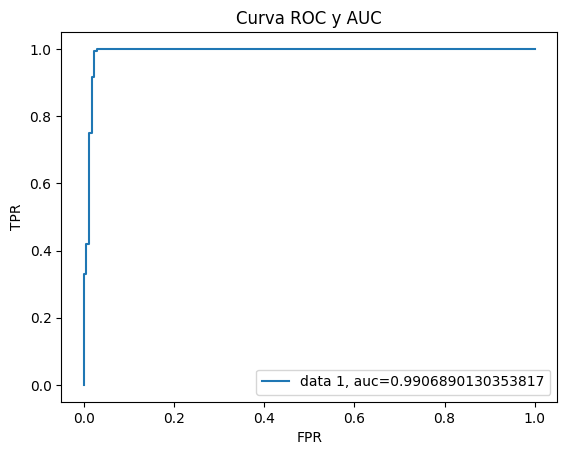

In [580]:
# ROC y AUC
y_pred_proba = final_model.predict_proba(X_test)[::,1]
fpr, tpr, th = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.title("Curva ROC y AUC")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()

**3. SVC**

In [581]:
parameters = { 
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 50, 100],
    'kernel' : ['rbf']
}

grid_search = GridSearchCV(SVC(probability=True, random_state=42), parameters, cv=10, n_jobs=-1, verbose=True)
grid_search.fit(X_train_scaled, y_train)

print("Mejores hiper parametros:", grid_search.best_params_)
print("Mejor estimator:", grid_search.best_estimator_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Mejores hiper parametros: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Mejor estimator: SVC(C=100, gamma=1, probability=True, random_state=42)


Accuracy:  0.9542857142857143
MSE:  0.18285714285714286
MAE:  0.09142857142857143
Precision:  0.9551187551187552
Recall:  0.9538697768630141
f1-score:  0.9542124542124543


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


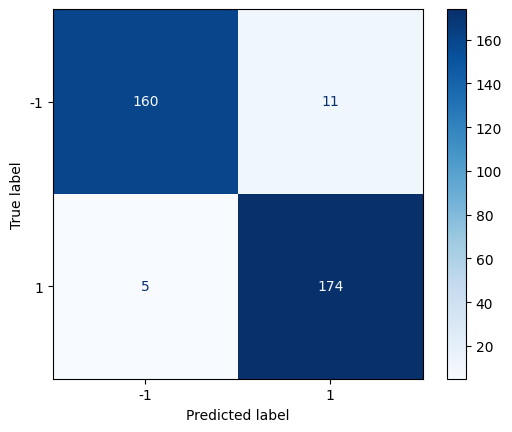

In [582]:
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test_scaled)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average="macro"))
print('Recall: ', recall_score(y_test, y_pred, average="macro", zero_division=0))
print('f1-score: ', f1_score(y_test, y_pred, average="macro"))
plot_confusion_matrix(final_model, X_test_scaled, y_test,cmap=plt.cm.Blues)

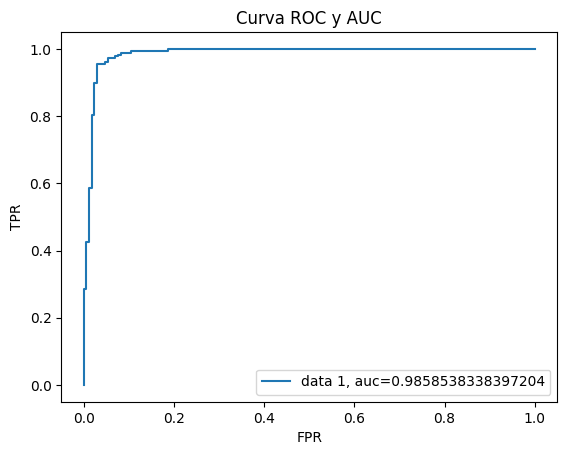

In [583]:
# ROC y AUC
y_pred_proba = final_model.predict_proba(X_test_scaled)[::,1]
fpr, tpr, th = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.title("Curva ROC y AUC")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()

**4. GradientBoostingClassifier**

In [584]:
parameters = {
    "learning_rate": [0.1,0.5,1.0],
    "max_depth":[1,2,4,8,10],
    "n_estimators":[10,100]
    }
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), parameters, cv=10, n_jobs=-1, verbose=True)
grid_search.fit(X_train,y_train)

print("Mejores hiper parametros:", grid_search.best_params_)
print("Mejor estimator:", grid_search.best_estimator_)


Fitting 10 folds for each of 30 candidates, totalling 300 fits
Mejores hiper parametros: {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 100}
Mejor estimator: GradientBoostingClassifier(learning_rate=0.5, max_depth=4, random_state=42)


Accuracy:  0.9857142857142858
MSE:  0.05714285714285714
MAE:  0.02857142857142857
Precision:  0.9864130434782609
Recall:  0.9853801169590644
f1-score:  0.9856945500322893


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


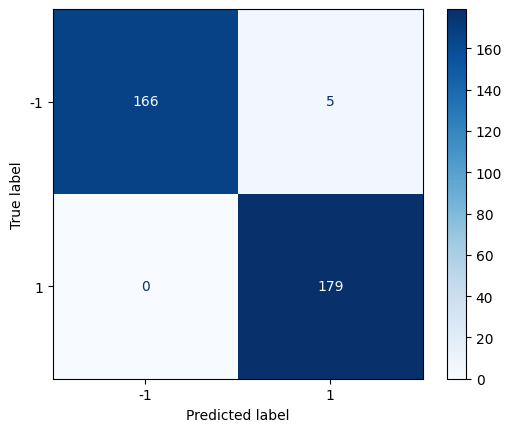

In [585]:
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average="macro"))
print('Recall: ', recall_score(y_test, y_pred, average="macro", zero_division=0))
print('f1-score: ', f1_score(y_test, y_pred, average="macro"))
plot_confusion_matrix(final_model, X_test, y_test,cmap=plt.cm.Blues)

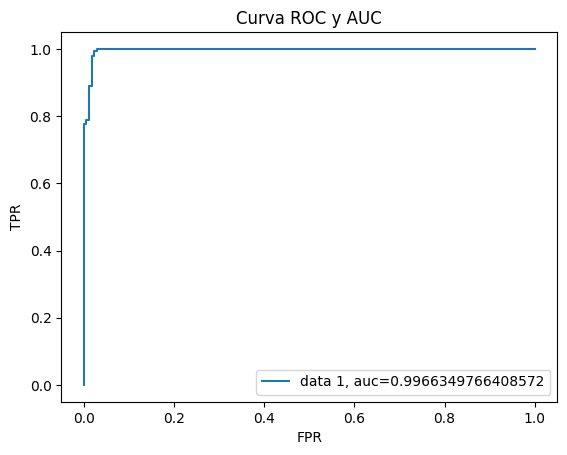

In [586]:
# ROC y AUC
y_pred_proba = final_model.predict_proba(X_test)[::,1]
fpr, tpr, th = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.title("Curva ROC y AUC")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()